# Class 21: Sampling Networks

1. Come in. Sit down. Open Teams.
2. Make sure your notebook from last class is saved.
3. Open up the Jupyter Lab server.
4. Run `git status` and `git add` and `git commit` anything that needs adding/committing.
5. Run `python3 git_fixer2.py`
6. Github:
    - git status (figure out what files have changed)
    - git add ... (add the file that you changed, aka the `_MODIFIED` one(s))
    - git commit -m "your changes"
    - git push origin main
________

## Goals of this lesson
1. Learn why sampling networks is useful
2. Think through different sampling procedures; be aware of the pros & cons
3. Practice sampling a large graph and getting approximate statistics by doing so.

## First, a challenge: 
The network we'll be using today is a high-energy physics citation network from [SNAP](https://snap.stanford.edu/data/cit-HepPh.html). It contains 34k nodes and 421k edges and spans about 10 years' worth of papers. 

We'll load the dataset here; next, your mission, should you choose to accept it, is to sample 500 nodes from the graph (you choose how) and induce a subgraph. We'll then see which subgraph most closely approximates the graph's actual degree distribution.

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

G_cites = nx.DiGraph()

df_edges = pd.read_csv('data/cit-HepPh/cit-HepPh.txt', sep='\t', header=3)
df_nodes = pd.read_csv('data/cit-HepPh/cit-HepPh-dates.txt', sep='\t', header=None)
df_nodes.columns = ['paper', 'date']
df_nodes['date'] = pd.to_datetime(df_nodes['date'])

for _, node in df_nodes.iterrows():
    G_cites.add_node(node['paper'], date=node['date'])

for _, edge in df_edges.iterrows():
    G_cites.add_edge(edge['FromNodeId'], edge['ToNodeId'])

In [15]:
# Your Turn:
# Sample 500 nodes from the dataset using any sampling procedure that speaks to you. 
# Next, induce a subgraph with these nodes. 
# In the next step, we'll look at this subgraph's degree distribution.
def induce_estimated_subgraph(G_cites, size=500):
    """
    Given a graph G_cites, return the subgraph induced by sampling $size nodes from G.
    The sampling procedure is your choice. 
    """
    sample_nodes = random.sample(list(G_cites.nodes), k=500)
    G_sample = G_cites.subgraph(sample_nodes)
    return G_sample

In [3]:
def degree_distribution(G, number_of_bins=15, log_binning=True, density=True, directed=False):
    """
    Given a degree sequence, return the y values (probability) and the
    x values (support) of a degree distribution that you're going to plot.
    
    Parameters
    ----------
    G (nx.Graph):
        the network whose degree distribution to calculate

    number_of_bins (int):
        length of output vectors
    
    log_binning (bool):
        if you are plotting on a log-log axis, then this is useful
    
    density (bool):
        whether to return counts or probability density (default: True)
        Note: probability densities integrate to 1 but do not sum to 1. 

    directed (bool or str):
        if False, this assumes the network is undirected. Otherwise, the
        function requires an 'in' or 'out' as input, which will create the 
        in- or out-degree distributions, respectively.
        
    Returns
    -------
    bins_out, probs (np.ndarray):
        probability density if density=True node counts if density=False; binned edges
    
    """

    # Step 0: Do we want the directed or undirected degree distribution?
    if directed:
        if directed=='in':
            k = list(dict(G.in_degree()).values()) # get the in degree of each node
        elif directed=='out':
            k = list(dict(G.out_degree()).values()) # get the out degree of each node
        else:
            out_error = "Help! if directed!=False, the input needs to be either 'in' or 'out'"
            print(out_error)
            # Question: Is this the correct way to raise an error message in Python?
            #           See "raise" function...
            return out_error
    else:
        k = list(dict(G.degree()).values()) # get the degree of each node


    # Step 1: We will first need to define the support of our distribution
    kmax = np.max(k)    # get the maximum degree
    kmin = 0            # let's assume kmin must be 0


    # Step 2: Then we'll need to construct bins
    if log_binning:
        # array of bin edges including rightmost and leftmost
        bins = np.logspace(0, np.log10(kmax+1), number_of_bins+1)
    else:
        bins = np.linspace(0, kmax+1, num=number_of_bins+1)


    # Step 3: Then we can compute the histogram using numpy
    probs, _ = np.histogram(k, bins, density=density)


    # Step 4: Return not the "bins" but the midpoint between adjacent bin
    #         values. This is a better way to plot the distribution.
    bins_out = bins[1:] - np.diff(bins)/2.0
    
    return bins_out, probs

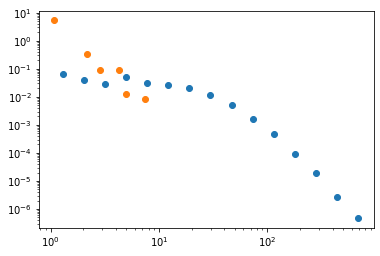

In [16]:
# plot the true degree distribution
x, y = degree_distribution(G_cites)
plt.loglog(x, y,marker='o',lw=0);

# now plot your subgraph's degree distribution using the same functionality. 
G_sample = induce_estimated_subgraph(G_cites, size=500)
x_s, y_s = degree_distribution(G_sample)
plt.loglog(x_s, y_s,marker='o',lw=0);

### Debriefing
What do you notice? Why might this be the case?

## Overview
In this class, we're going to practice sampling our large-ish citation graph to learn about ways to deal with large networks. The sampling procedures and evaluation paradigms we'll use will closely follow [Leskovec and Faloutsos (2006)](https://cs.stanford.edu/people/jure/pubs/sampling-kdd06.pdf). 

### Why Sample?
Sometimes it just isn't feasible to analyze an entire graph. We might not have enough time, computational budget, or storage space to look at the entirety of an enormous network. Some algorithms for computing, say, centrality or shortest paths become infeasible (or at least really annoying) on graphs that have, say, billions of edges. The research questions Leskovec and Faloutsos focus on are the following:
1. How do we sample? What method(s) should we use?
2. How small can our sample size be?
3. How do we scale up the measurements from our sample (e.g. diameter) to get estimates for the whole graph?
4. How do we know if we've done a good job sampling & scaling up?

### Two sampling goals
L & F introduce two different goals for sampling a network. The first ideal sample is a **scaled-down** sample: our sample graph $S$, derived from our whole graph $G$, has properties that are either similar to $G$ or predictably scaled down. Our second ideal sampling goal is a **back-in-time** sample; this one looks like $G$ *at the time it was the size of $S$*. 

### What properties do we care about?
#### For a static snapshot:
* In-degree distribution (should probably follow a heavy-tailed power law distribution)
* Out-degree distribution (should also probably follow a heavy-tailed power law distribution)
* The distribution of weakly connected components' sizes (weakly connected in a directed graph = an **undirected** path exists between any node pair $(u,v)$ in the component)
* The distribution of strongly connected components' sizes (strongly connected in a directed graph = a **directed** path exists between any node pair $(u, v)$ in the component). 
* Hop-plot (the number of reachable pairs of nodes $P(h)$ at distance $h$ or less)
* Hop-plot on the largest WCC (weakly connected component)
* The distribution of the first left singular vector of the graph adjacency matrix versus the rank
* The distribution of singular values of the graph adjacency matrix versus the rank
* The distribution of the clustering coefficient (averaged over each degree)

#### For a back-in-time sample:
* Densification Power Law: the average degree of nodes over time (should increase over time according to $k(t) \propto n(t)^\alpha$, where $\alpha > 1$)
* The effective diameter over time: the minimum number of hops in which 90% of nodes can reach each other. This should shrink or stabilize as the graph grows over time
* The normalized size of the largest connected component over time
* The largest singular value of the graph adjacency matrix over time.
* Average per-degree clustering coefficient over time

(these are measured on a sequence of graphs over time!)

#### Visiting probability:
We also look at visiting probability, which is the probability that if you start a random walk at node $v$ you visit node $w$ (for every node $v$, we calculate the stationary distribution of a random walk starting at $v$ and compare the distributions in $S$ and $G$). 

### Interactive Moment
What kinds of properties do you think we should care about? Do you think this list captures the right information?

### Testing whether we got it right
L & F use the Kolmogorov-Smirnov D-statistic ($D = max_x{|F'(x) - F(x)|}$), or "how wrong are we at the point in the cumulative distribution function where we're maximally wrong?" to determine how good a sample is at predicting a particular property. Recall that the K-S test is usually used to test whether a sample came from a particular distribution without regard for the type of underlying distribution we're looking at (this means it is *nonparametric*). Here, $F'(x)$ is our sample CDF and $F(x)$ is our CDF for $G$, the original enormous graph. 


 ## Sampling Methods
 There are a lot of ways we can sample graphs. Leskovec and Faloutsos introduce several, so we'll go through the highlight reel. 
 
 ## Random Node Selection
 
 #### Random Node Sampling
 This is where we grab a random set of nodes and induce a subgraph with just this set of nodes. This does **not** retain a power-law degree distribution. Let's sample 50 random nodes from the citation graph. Then we'll look at the degree distribution in the induced subgraph.

In [19]:
nodes_to_keep = random.sample(list(G_cites.nodes), 500)
G_cite_rns = G_cites.subgraph(nodes_to_keep)

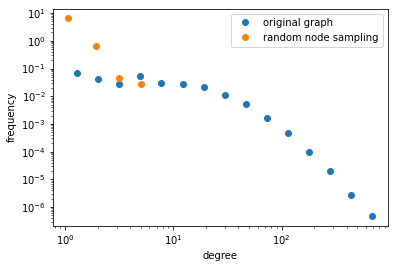

In [26]:
plt.ylabel('frequency')
plt.xlabel('degree')
# plot the true degree distribution
x, y = degree_distribution(G_cites)
plt.loglog(x, y,marker='o',lw=0, label='original graph')

# now plot your subgraph's degree distribution using the same functionality. 
x_s, y_s = degree_distribution(G_cite_rns)
plt.loglog(x_s, y_s,marker='o',lw=0, label='random node sampling')
plt.legend()

### Let's Investigate Further: 
Did any of these sampling techniques produce an induced subgraph with a degree distrubtion you think is plausible? 

Next, write code to answer one of the following questions: 
1. What does the distribution of connected components' sizes look like in this sample? Is this useful behavior?
2. What does the distribution of centralities (pick your favorite measure that **is not** degree centrality) for the sample graph and the ground truth graph? Is this what you'd expect?
3. What results do we get when we sample nodes according to their [PageRank](https://en.wikipedia.org/wiki/PageRank) weight or their degree? Is this a better sampling procedure?
4. Construct the hop-plot for the full graph and a sampled subgraph of your choice. In a hop-plot, $P(h)$ refers to how many nodes are reachable from one another at a shortest path distance $\leq h$. How do these plots compare?

## Sampling using Edges

### Random Edge Sampling
We can also sample edges at random; what problems can you foresee with this approach? These will tend to have sparse connectivity and lack community structure. What about the graph diameter? Will it be what you expect it to be?

### Random Node-Edge Sampling
This is where we pick a random node (uniformly at random) and then pick an edge incident to that node. This tends to perform better, but it is biased towards higher-degree nodes -- can you explain why that might be the case? 

Let's give both of these a try; we'll do random edge sampling first!

In [22]:
# Random edge sampling
import random
edges_to_keep = random.sample(list(G_cites.edges()), 500)

set_of_nodes_to_keep = set()
# keeping nodes that are incident to a sampled edge
for e in edges_to_keep:
    set_of_nodes_to_keep.add(e[0])
    set_of_nodes_to_keep.add(e[1])
    
G_cite_res = G_cites.subgraph(list(set_of_nodes_to_keep))

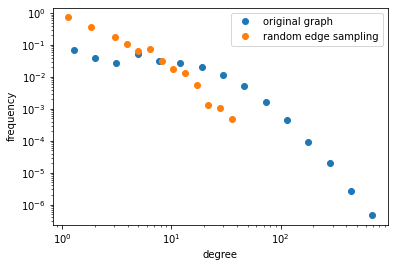

In [25]:
plt.ylabel('frequency')
plt.xlabel('degree')
# plot the true degree distribution
x, y = degree_distribution(G_cites)
plt.loglog(x, y,marker='o',lw=0, label='original graph')

# now plot your subgraph's degree distribution using the same functionality. 
x_s, y_s = degree_distribution(G_cite_res)
plt.loglog(x_s, y_s,marker='o',lw=0, label='random edge sampling')
plt.legend()

### Your Turn!
Now it's your turn to implement random node-edge sampling (RNES). 

In [ ]:
# Random node-edge sampling

nodes_to_keep = set()
for i in range(500):
    # sample a node and an edge incident on it. 
    # keep the node and its neighbor on that edge.
    
G_cite_rnes = G_cites.subgraph(list(nodes_to_keep))

In [ ]:
plt.ylabel('frequency')
plt.xlabel('degree')
# plot the true degree distribution
x, y = degree_distribution(G_cites)
plt.loglog(x, y,marker='o',lw=0, label='original graph')

# now plot your subgraph's degree distribution using the same functionality. 
x_s, y_s = degree_distribution(G_cite_rnes)
plt.loglog(x_s, y_s,marker='o',lw=0, label='random node-edge sampling')
plt.legend()

### Let's Investigate Further (again):
Did any of these sampling techniques produce an induced subgraph with a degree distrubtion you think is plausible? 

Next, write code to answer **another** of the following questions (i.e. a different question from the one you answered in the previous section): 
1. What does the distribution of connected components' sizes look like in this sample? Is this useful behavior?
2. What does the distribution of centralities (pick your favorite measure that **is not** degree centrality) for the sample graph and the ground truth graph? Is this what you'd expect?
3. What results do we get when we sample **edges** according to their [PageRank](https://en.wikipedia.org/wiki/PageRank) weight or their **betweenness**? Is this a better sampling procedure?
4. Construct the hop-plot for the full graph and a sampled subgraph of your choice. In a hop-plot, $P(h)$ refers to how many nodes are reachable from one another at a shortest path distance $\leq h$. How do these plots compare?


## Sampling by Exploration

### Random Node-Neighbor Sampling
Here, we select a node uniformly at random **and** gather up all its neighbors as well. This tends to match out-degree distribution pretty well, but in-degree distribution and community structure don't match up quite as nicely.

### Random Walk Sampling
We pick a node uniformly at random and then pick a random neighbor to go to. Then we go to a randomly chosen neighbor of *that* node, and so on. However, at each step, with probability $p$ (usually $p = 0.15$ in the literature), we go back to our start node and restart the walk. If we do a bunch of steps and don't visit enough nodes to get a large enough sample, we pick another node as our start node (this assumes we found a small component or a node that is a sink). 

### Random Jump Sampling
This is the same as random walk sampling, except with probability $p$, instead of going back to our start node, we jump to another randomly chosen node in the graph (drawn uniformly at random). This avoids the concerns about getting stuck that we had with random walk sampling.

Let's implement random jump sampling. Keep sampling until you have 5000 nodes, and then tell me about your degree distribution!

In [ ]:
# Your Turn!
G_cite_rjs = nx.DiGraph()

while len(G_cite_rjs.nodes) < 5000:
    # do something

In [ ]:
plt.ylabel('frequency')
plt.xlabel('degree')
# plot the true degree distribution
x, y = degree_distribution(G_cites)
plt.loglog(x, y,marker='o',lw=0, label='original graph')

# now plot your subgraph's degree distribution using the same functionality. 
x_s, y_s = degree_distribution(G_cite_rjs)
plt.loglog(x_s, y_s,marker='o',lw=0, label='random jump sampling')
plt.legend()

## Forest Fire Sampling
Okay, so that was pretty neat! We saw a more plausible degree distrubtion, and we got to do some random walking. All of these sampling procedures attempt to get at the **scaled-down** sampling objective, where we want to approximate characteristics of the (static) original graph as best we can. However, there's also a **back-in-time** sampling objective, where we want to see an accurate depiction of what the graph would've looked like earlier in its evolution. 

With that in mind, we're going to look at another type of sampling that Leskovec and Faloutsos suggest for the **back-in-time** sampling goal. It's called **Forest Fire Sampling**, and you start by randomly picking a seed node $v$. Then we pick a random number $x$ that's geometrically distributed with mean $m = \frac{p_f}{1-p_f}$: $p(x) = (1-m)^k m$. We select $x$ of $v$'s out-links. For each out-link, we choose to burn it with probability $p_f$. If a link $(v, w)$ burns, the node $w$ at its endpoint also can burn its own links, and so on. L & F found that this works pretty well for back-in-time sampling with relatively low values of $p_f$ ($0 \leq p_f \leq 0.4$) and for static sampling with higher values of $p_f$ ($p_f \geq 0.6$). 
 
 
Let's attempt forest fire sampling with different values of $p_f$. We'll then compare our results to an older version of the graph. 

In [28]:
from littleballoffur import ForestFireSampler

# because this code is grumpy, we have to give each node a numeric index starting at 0.
import networkx as nx
import pandas as pd

G_cites_sequential = nx.relabel_nodes(G_cites, {node:idx for idx, node in enumerate(G_cites.nodes)})


Text(0.5, 1.0, 'all nodes')

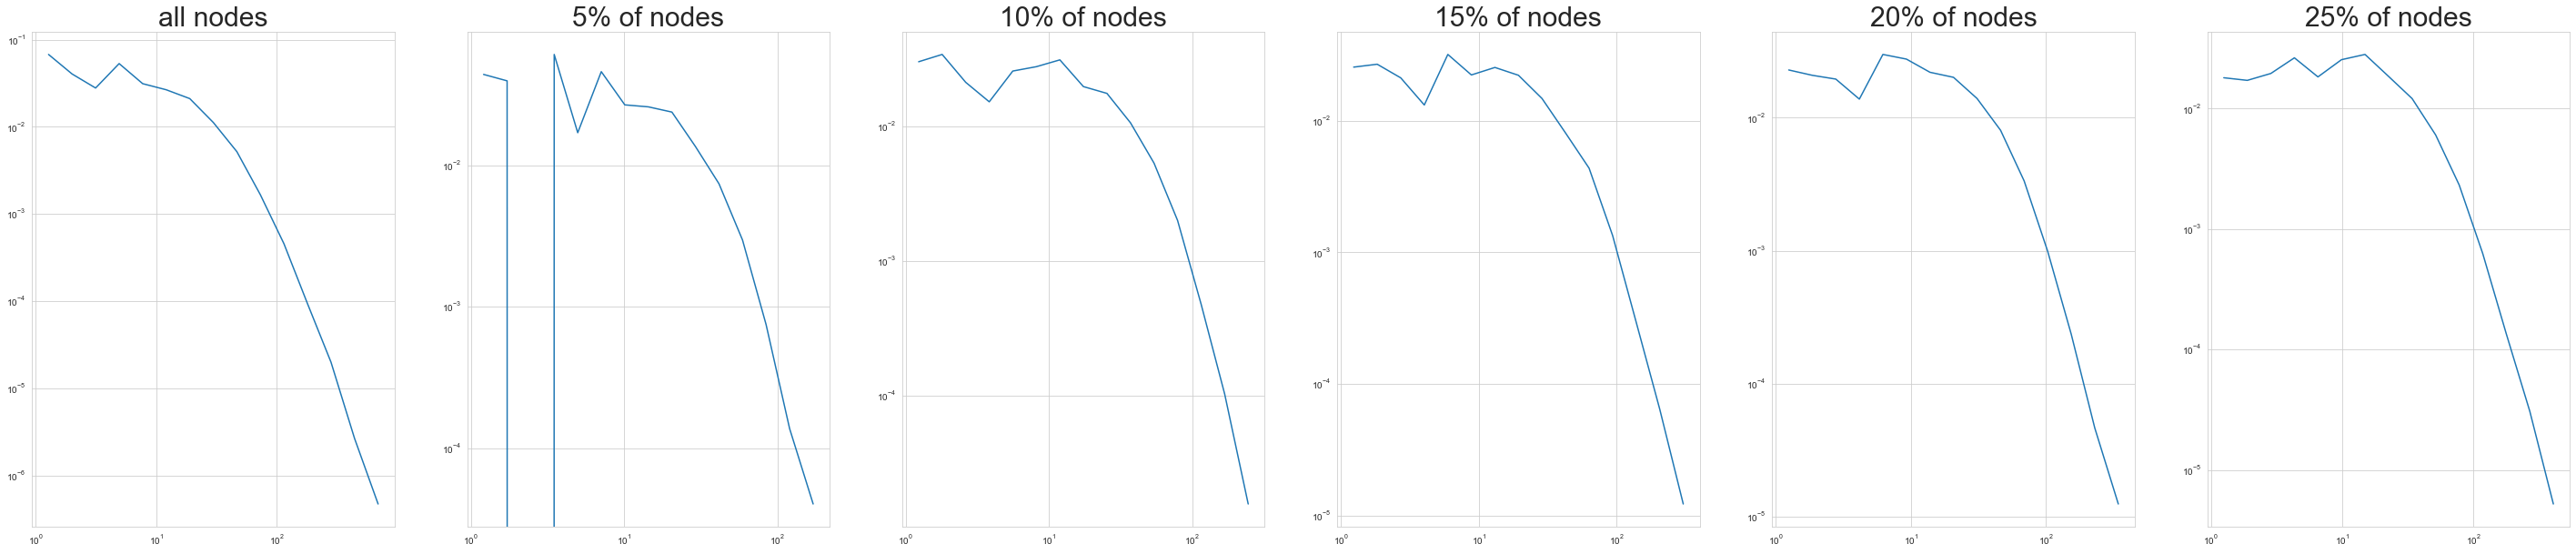

In [32]:
# First we'll try different sample sizes:
plt.rcParams['figure.figsize'] = (50, 10)

fig, ax = plt.subplots(1, 6)
for idx in range(1, 6):
    G_cite_ffs = ForestFireSampler(number_of_nodes = idx * int( len(G_cites.nodes)/20)).sample(
        G_cites_sequential.to_undirected()
    )
    x_s, y_s = degree_distribution(G_cite_ffs)
    ax[idx ].loglog(x_s, y_s)

    ax[idx ].set_title(str(5 * idx) + '% of nodes', size=30)
#     ax[idx ].set_xscale('log')
#     ax[idx ].set_yscale('log')
    
x, y = degree_distribution(G_cites)
ax[0].loglog(x, y)
ax[0].set_title('all nodes', size=30)



Text(0.5, 1.0, 'all nodes')

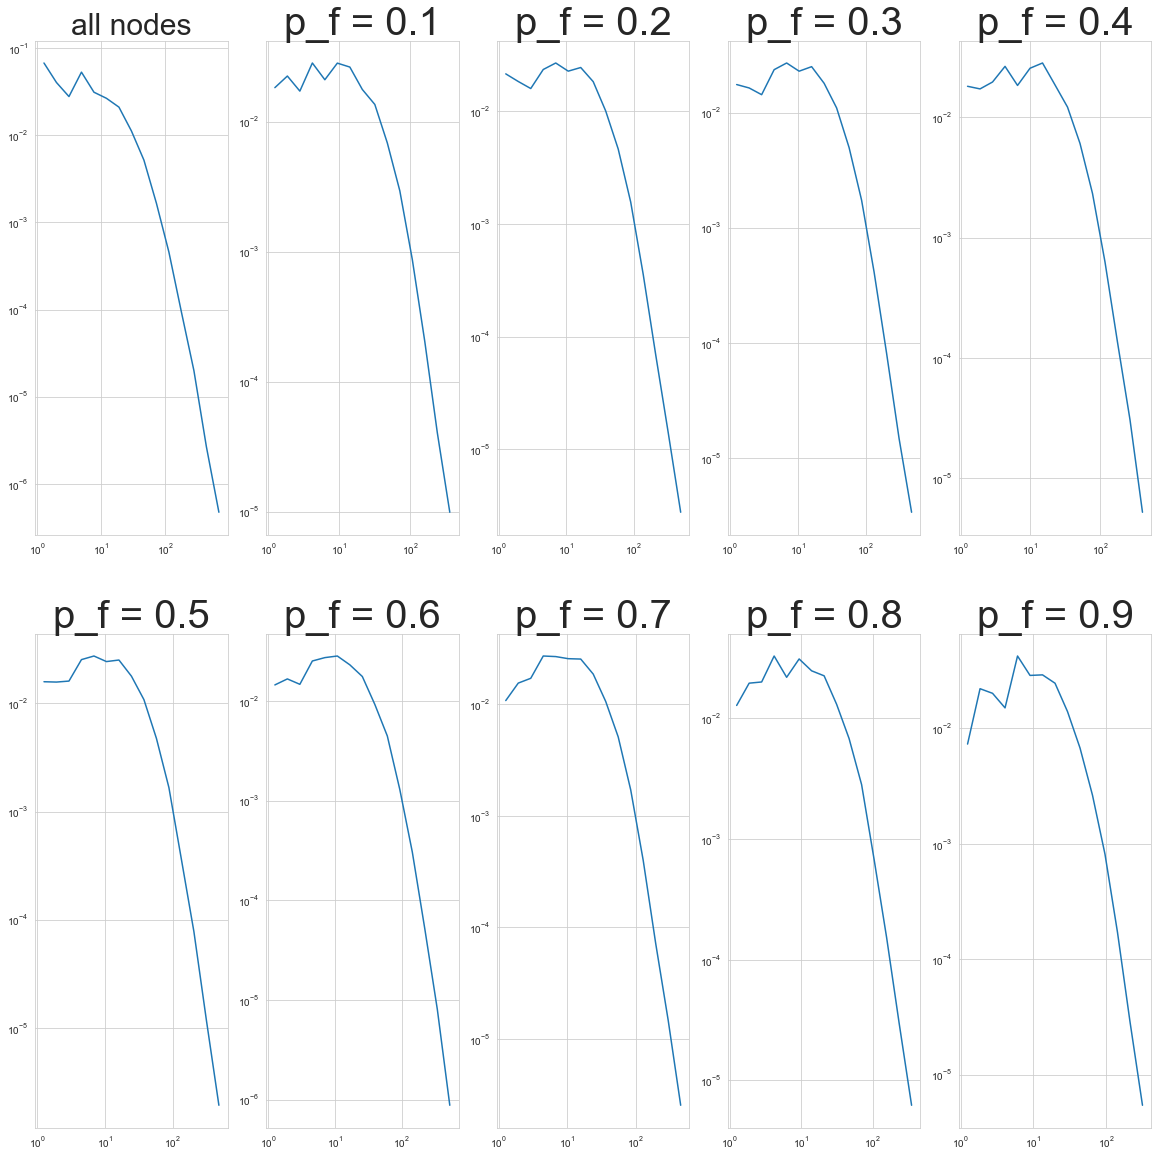

In [44]:
plt.rcParams['figure.figsize'] = (20, 20)

fig, axs = plt.subplots(2, 5)
for idx, ax in zip(range(1, 10), axs.ravel()[1:]):
    G_cite_ffs = ForestFireSampler(p=0.1 * idx, number_of_nodes = 5 * int( len(G_cites.nodes)/20)).sample(
        G_cites_sequential.to_undirected()
    )
    x_s, y_s = degree_distribution(G_cite_ffs)
    ax.loglog(x_s, y_s)
    ax.set_title("p_f = %.1f"%(0.1 * idx), size=40)

x, y = degree_distribution(G_cites)
axs[0, 0].loglog(x, y)
axs[0, 0].set_title('all nodes', size=30)

### Comparing to previous iterations of the graph

Let's look at versions of the graph that existed before 1993, 1994, 1995, and 1996. We'll compare them to our forest fire sampling results and see how they stack up.

/Users/a404/aaa/lib/python3.9/site-packages/networkx/utils/decorators.py:1254: FutureWarning: Pass filter_node=<function <lambda> at 0x190322d30> as keyword args. From NetworkX version 3.4 passing these as positional arguments will result in an error
  warnings.warn(
/Users/a404/aaa/lib/python3.9/site-packages/networkx/utils/decorators.py:1254: FutureWarning: Pass filter_node=<function <lambda> at 0x190186310> as keyword args. From NetworkX version 3.4 passing these as positional arguments will result in an error
  warnings.warn(
/Users/a404/aaa/lib/python3.9/site-packages/networkx/utils/decorators.py:1254: FutureWarning: Pass filter_node=<function <lambda> at 0x190212f70> as keyword args. From NetworkX version 3.4 passing these as positional arguments will result in an error
  warnings.warn(
/Users/a404/aaa/lib/python3.9/site-packages/networkx/utils/decorators.py:1254: FutureWarning: Pass filter_node=<function <lambda> at 0x190285c10> as keyword args. From NetworkX version 3.4 passing

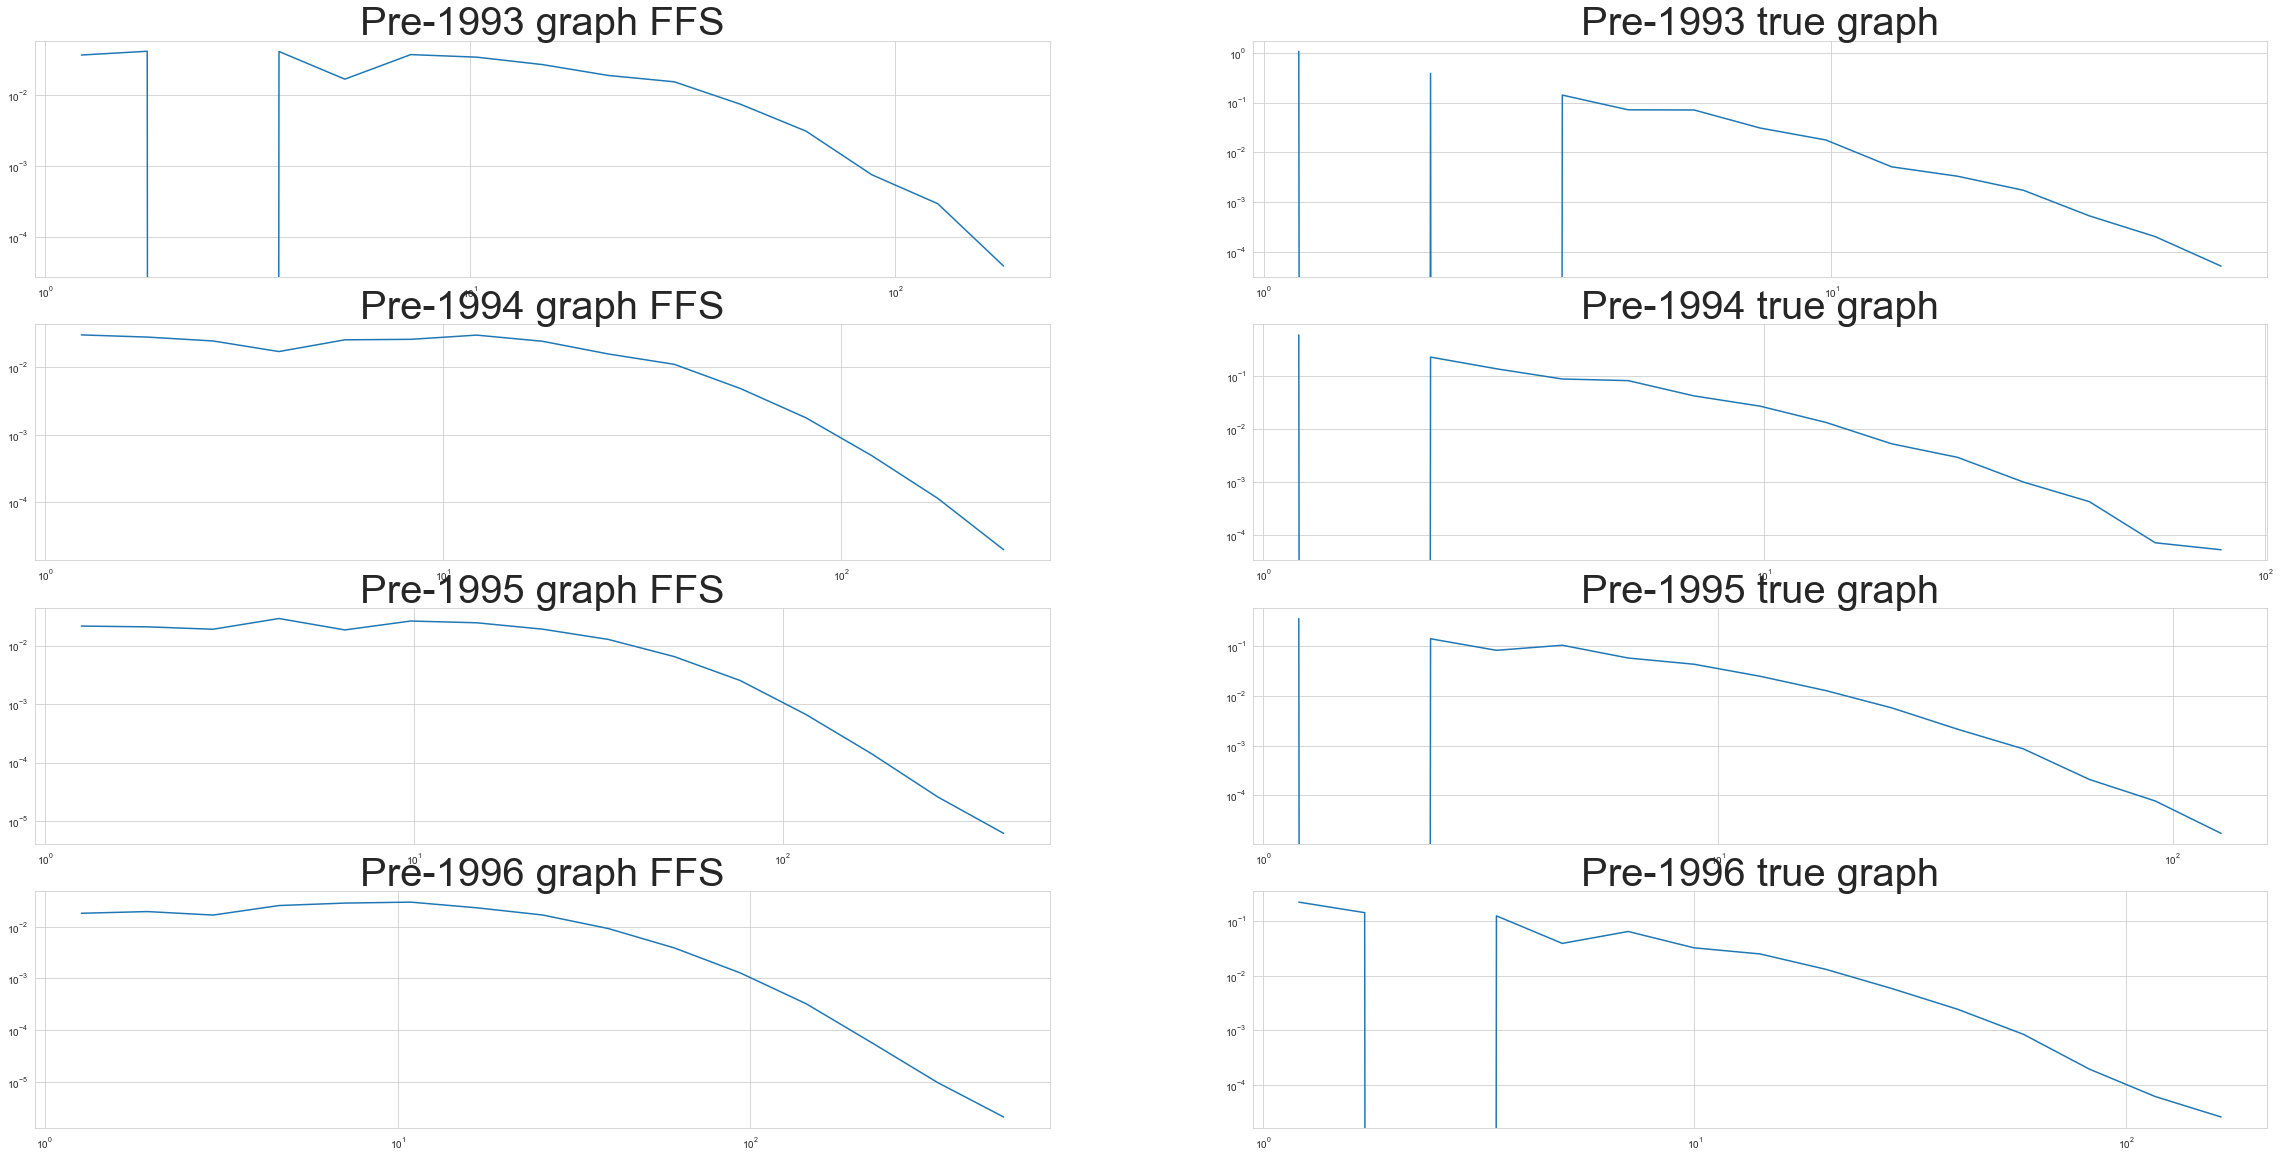

In [46]:
# Your Turn!

plt.rcParams['figure.figsize'] = (40, 20)

# toggle values of P_f to see if any produce an optimal result.
P_f = 0.25

def retrieve_year(node):
    """
    Helper function to grab the year of a node (paper) from G_cites.
    """
    try:
        return G_cites.nodes[node]['date'].year
    except Exception as e:
        return 2024
    
fig, ax = plt.subplots(4, 2)
for idx, yr in enumerate([1993, 1994, 1995, 1996]):
    G_cite_year = nx.subgraph_view(G_cites, lambda b:retrieve_year(b) <= yr)
    G_cite_ffs = ForestFireSampler(p=P_f, number_of_nodes = len(G_cite_year)).sample(
        G_cites_sequential.to_undirected()
    )
    
    x_s, y_s = degree_distribution(G_cite_ffs)
    ax[idx, 0].loglog(x_s, y_s)
    ax[idx, 0].set_title('Pre-' + str(yr) + ' graph FFS', size=40)
    
    x_y, y_y = degree_distribution(G_cite_year)
    ax[idx, 1].loglog(x_y, y_y)


    ax[idx, 1].set_title('Pre-' + str(yr) + ' true graph', size=40)

## Your Turn: Using the K-S Statistic to Compare Distributions
We've just developed a whole toolkit of sampling methods. Now, pick a distribution that characterizes the network, like:

- The size of connected components
- The hop-plot 
- The degree of nodes
- The edge betweenness 

(and many more!)

Next, pick a few sampling methods and sample a graph (ideally several) using each method (size $\leq 1000$). Compute the K-S statistic of the original graph's distribution and that of the sampled graph(s). 

Visualize the differences in K-S statistics between sampling methods. You might make a box-and-whisker plot, a heatmap, or whatever else helps you best convey the differences between methods. 

## Resources & Acknowlegements

This class is heavily based off of [Leskovec and Faloutsos (2006)](https://cs.stanford.edu/people/jure/pubs/sampling-kdd06.pdf).

To try out a bunch of network sampling algorithms, check out [littleballoffur](https://github.com/benedekrozemberczki/littleballoffur)

An [article](https://www.annualreviews.org/content/journals/10.1146/annurev-soc-060116-053556) on network sampling with people (useful for qualitative research)